In [1]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [2]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re

In [3]:
api = wandb.Api(timeout=19)

In [4]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [5]:
def same_config(config1, config2, keys=['normtype']):
    for key in keys:
        if config1[key] != config2[key]:
            return False
    return True

In [6]:
bright_factor = 0.75
best_n_runs = 3
runs_dict = dict()
runs_dict["runs_vanilla_dann"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 0,
                                                            "config.use_testset": True, "config.momentum": 0.9}, order="-summary_metrics.test_acc")
runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 1,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")
runs_dict["runs_homeostasis_I_only"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0,
                                                                    "config.use_testset": True, "config.task_opt_inhib": 0, "config.use_sep_bias_gain_lrs": 0, "config.lambda_homeo": 1,
                                                                    "config.homeostatic_annealing": None }, order="-summary_metrics.test_acc")
runs_dict["runs_homeostasis_I_frozen"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0,
                                                                    "config.use_testset": True, "config.task_opt_inhib": 0, "config.use_sep_bias_gain_lrs": 0, 
                                                                    "config.lambda_homeo": 0,  "config.homeostatic_annealing": 0 }, order="-summary_metrics.test_acc")
runs_dict["runs_homeostasis_I_frozen_LN"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 1,
                                                                    "config.use_testset": True, "config.task_opt_inhib": 0, "config.use_sep_bias_gain_lrs": 0, 
                                                                    "config.lambda_homeo": 0, "config.homeostatic_annealing": 0 }, order="-summary_metrics.test_acc")
runs_dict["runs_homeostasis_EI"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0,
                                                                    "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                    "config.homeostatic_annealing": 0, "config.lambda_homeo": 1, "config.momentum": 0.9 }, order="-summary_metrics.test_acc")

dict_keys([0.1, 0.046416, 0.8, 0.021544, 0.21544, 4.6416, 1.5, 1, 0.01, 0.46416, 2.1544, 10, 20, 100, 50])
dict_keys([1, 0.01, 0.46416, 0.021544, 0.046416, 0.1, 1.5, 0.21544, 100, 4.6416, 20, 0.8, 50, 10, 2.1544])
dict_keys([100, 1.5, 50, 20, 0.8, 10, 2.1544, 4.6416, 1, 0.46416, 0.21544, 0.1, 0.01, 0.046416, 0.021544])
dict_keys([0.1, 0.21544, 0.046416, 0.021544, 1.5, 50, 0.8, 20, 0.01, 2.1544, 10, 4.6416, 1, 0.46416, 100])
dict_keys([0.46416, 0.8, 0.21544, 20, 1, 100, 2.1544, 4.6416, 10, 1.5, 50, 0.1, 0.021544, 0.01, 0.046416])


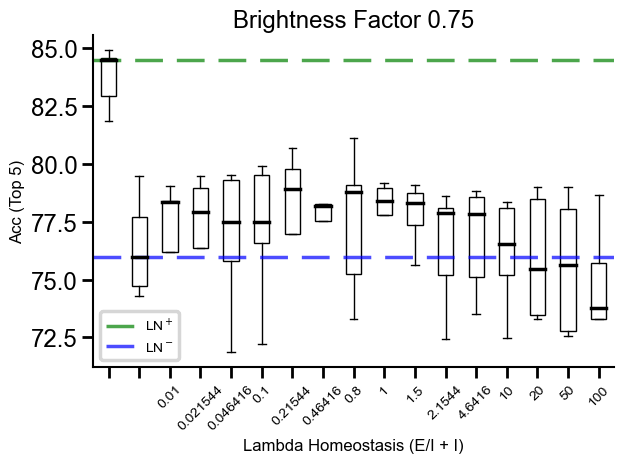

In [13]:
fig, ax = plt.subplots()

EI = fetch_runs(api, entity='project_danns', project_name='Luminosity_DeepDANN', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bright_factor, "config.homeostasis": 1, "config.normtype": 0,
                                                                    "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                    "config.homeostatic_annealing": 0 }, order="-summary_metrics.test_acc")


data = []

best_LN_plus = []
best_LN_minus = []

EI_lambdas = {}

top_n = 5

for top in range(top_n):
    best_acc_run_ln_config = 0

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']

    best_LN_minus.append(vanilla_dann_acc)
    #print(f"Model {top}: {vanilla_dann_acc}")
    EI_lambdas_temp = {}

    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            if rn.summary['test_acc'] > best_acc_run_ln_config:
                best_acc_run_ln_config = rn.summary['test_acc']

    for rn in EI:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd', 'momentum', 'inhib_lrs']):
            if rn.config['lambda_homeo'] in EI_lambdas_temp.keys():
                EI_lambdas_temp[rn.config['lambda_homeo']].append(rn.summary['test_acc'])
            else:
                EI_lambdas_temp[rn.config['lambda_homeo']] = [rn.summary['test_acc']]

    best_LN_plus.append(best_acc_run_ln_config)

    print(EI_lambdas_temp.keys())

    for ky in EI_lambdas_temp.keys():
        if ky in EI_lambdas.keys():
            EI_lambdas[ky].extend(sorted(EI_lambdas_temp[ky])[-1:])
        else:
            EI_lambdas[ky] = sorted(EI_lambdas_temp[ky])[-1:]

data.extend([best_LN_plus, best_LN_minus])

sorted_keys = sorted(EI_lambdas.keys())

for ky in sorted_keys:
    data.append(EI_lambdas[ky][:top_n])


bp = ax.boxplot(np.array(data).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                        showfliers=False)

DANN_BASELINE_LN_MEDIAN = bp['medians'][0].get_ydata()[0]
DANN_BASELINE_MEDIAN = bp['medians'][1].get_ydata()[0]

    #elements.append(bp)
# Create custom x-axis tick labels
label_keys = ["",  ""]
label_keys.extend([str(el) for el in sorted_keys])
custom_xticks = [el for el in label_keys]
ax.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax.set_xticklabels(custom_xticks, fontsize=10,  rotation=45)

ax.set_xlabel(f'Lambda Homeostasis (E/I + I)')
ax.set_ylabel(f'Acc (Top {top_n})')
ax.set_title(f'Brightness Factor {bright_factor}')
plt.axhline(y=DANN_BASELINE_LN_MEDIAN, color='green', linestyle='--', alpha=0.7, label='LN$^+$')
plt.axhline(y=DANN_BASELINE_MEDIAN, color='blue', linestyle='--', alpha=0.7, label='LN$^-$')
plt.legend(loc='best', fontsize="10")
